In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
#
# The original jupyter notebook is at: https://osf.io/5cw7n
# paper:
# Sassenhagen J, Draschkow D.
# Cluster-based permutation tests of MEG/EEG data do not establish significance
# of effect latency or location. Psychophysiology. 2019; 56:e13335.
# https://doi.org/10.1111/psyp.13335

# minimal changes made to this notebook by 
# peter hebden.   
# phebden@gmail.com
#
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

from sklearn.preprocessing import minmax_scale
import pandas as pd
import seaborn as sns

from multiprocessing import Pool
import tqdm

import mne
mne.set_log_level(False)

# conda --version && python --version
# conda 23.10.0
# Python 3.11.5
# python -c "import mne; print(mne.__version__)"
# 1.6.1
import platform
print("using python version: ", platform.python_version())
print("using mne version: ", mne.__version__)
print("using numpy version: ", np.__version__)

using python version:  3.11.5
using mne version:  1.6.1
using numpy version:  1.26.3


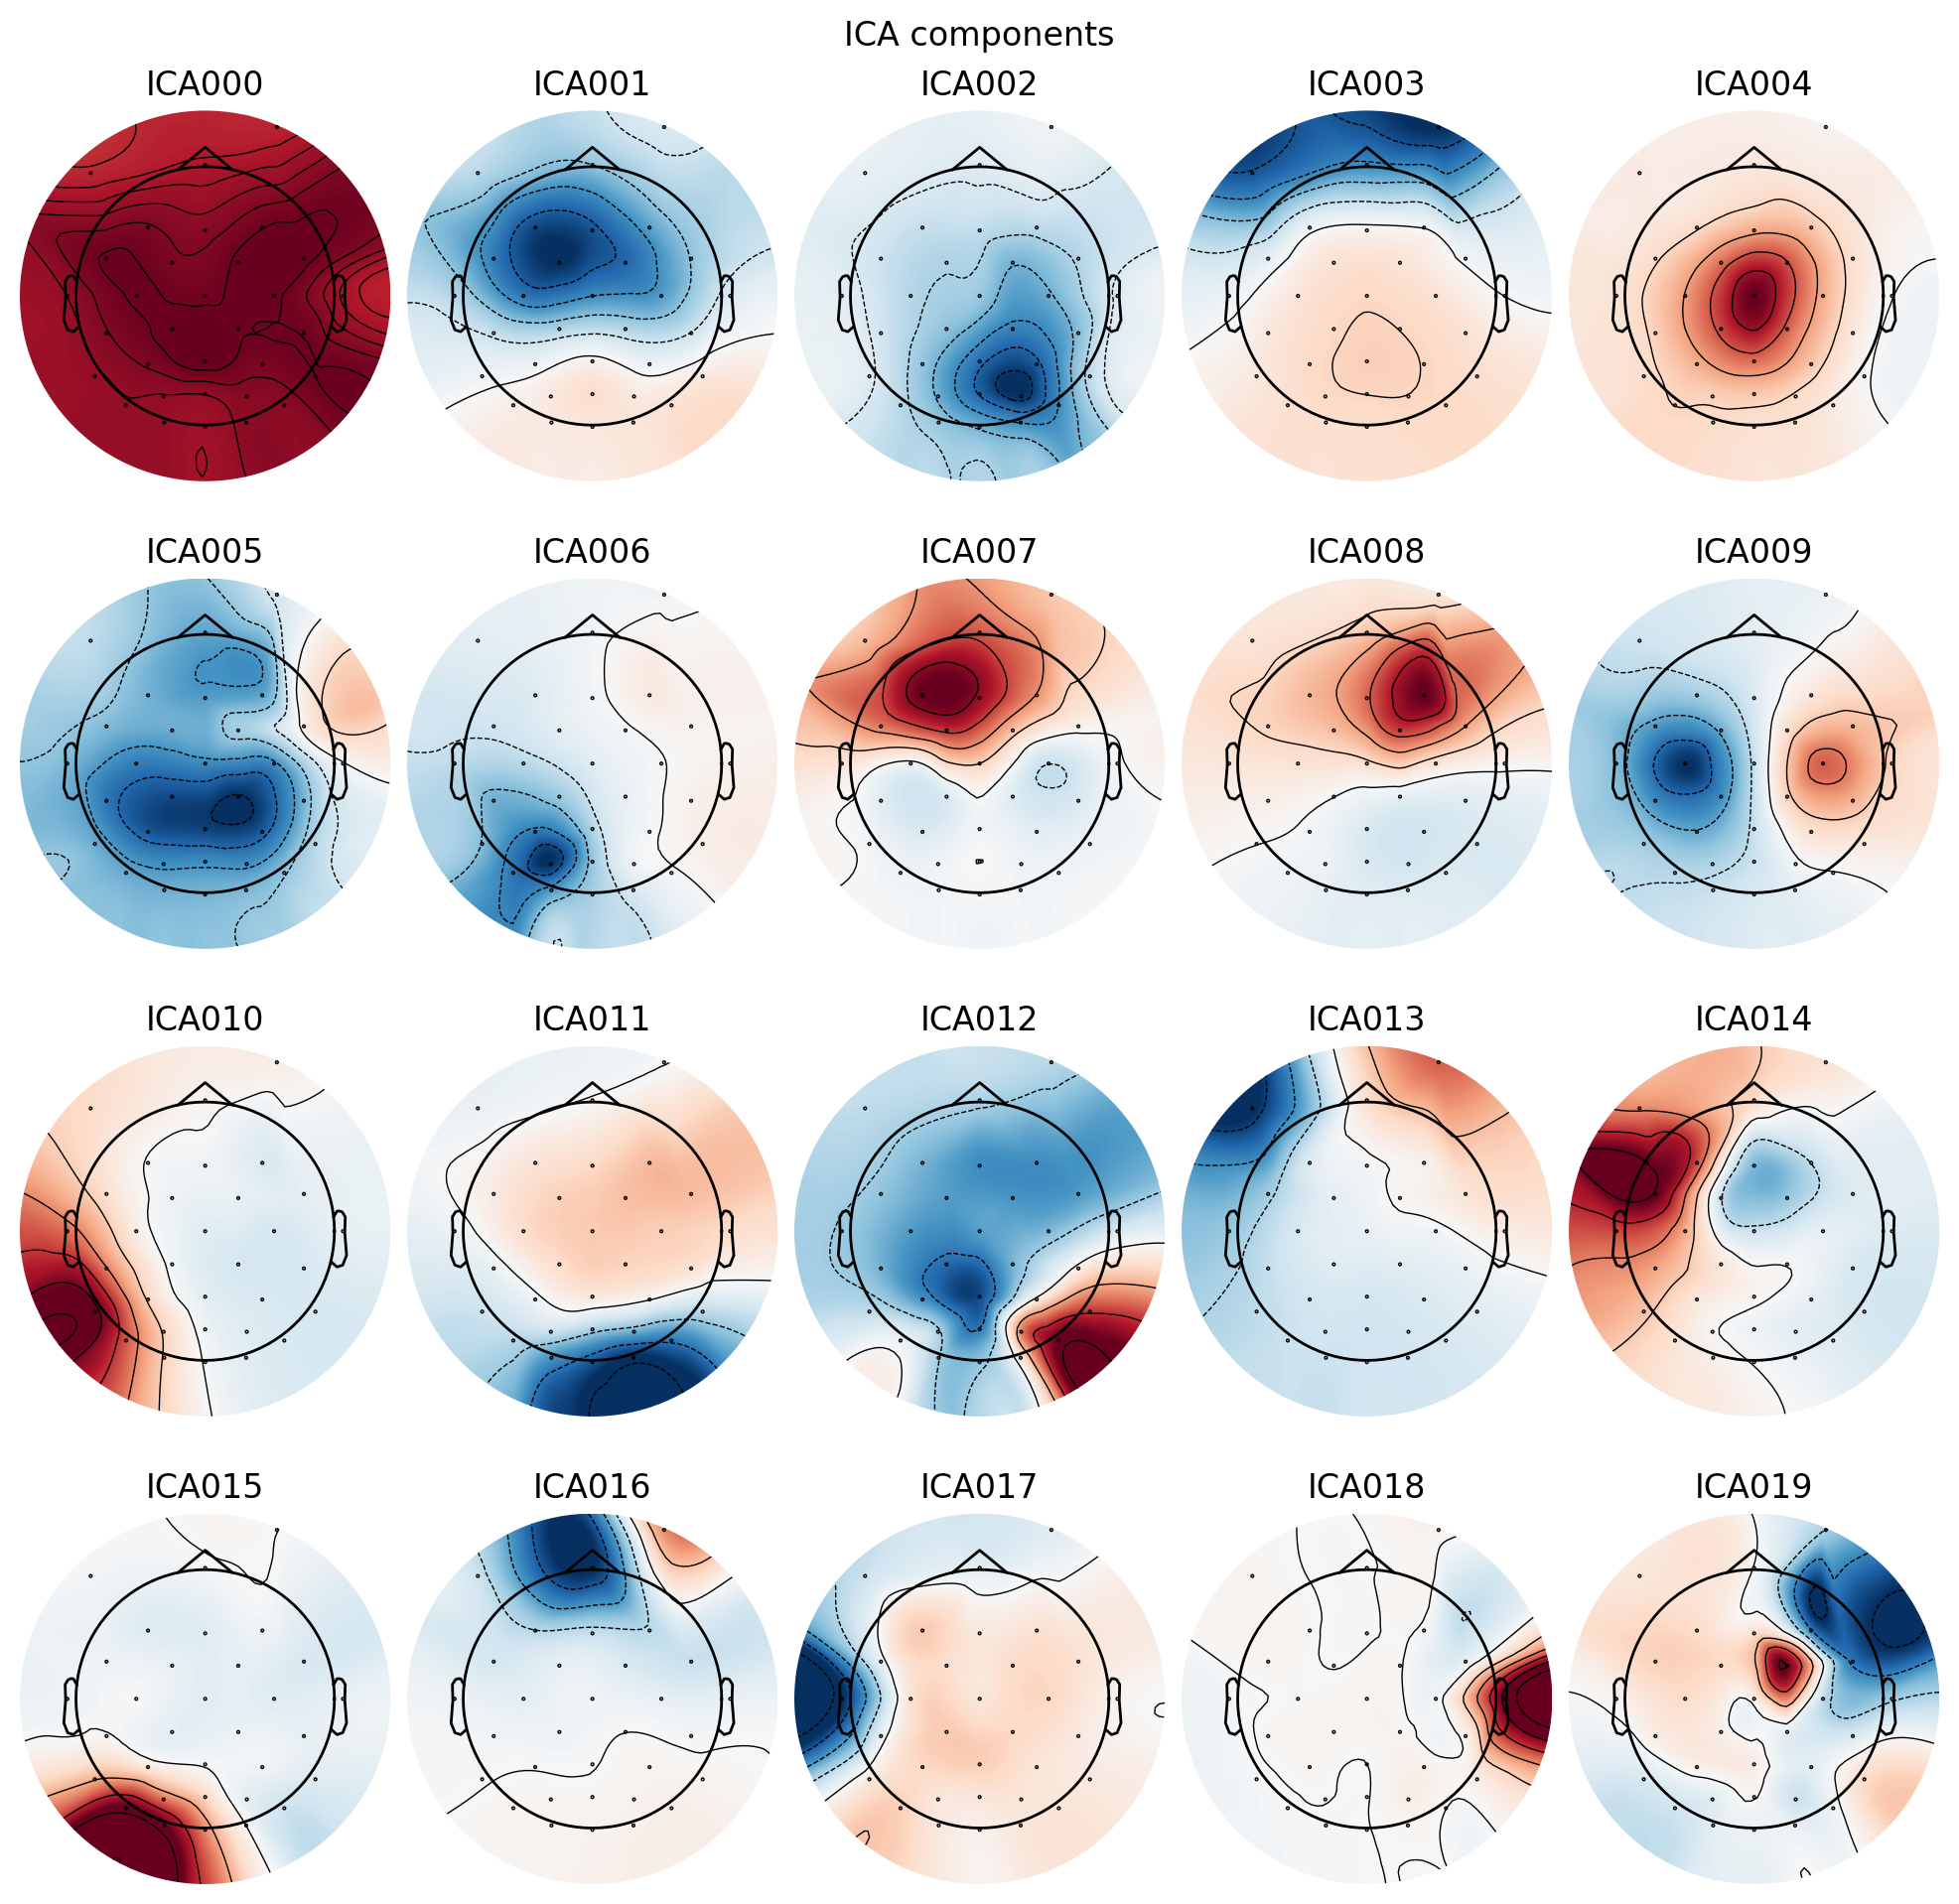

In [4]:
from mne.datasets import testing

data_path = testing.data_path()
fname = data_path / "EEGLAB/test_raw.set"

locs_info_path = data_path / "EEGLAB/test_chans.locs"

raw = mne.io.read_raw_eeglab(fname, preload=True)

montage = mne.channels.read_custom_montage(locs_info_path)
# import correct channel names
new_chan_names = np.loadtxt(locs_info_path, dtype=str, usecols=3)
# get old channel names
old_chan_names = raw.info["ch_names"]
# create a dictionary to match old channel names and new (correct) channel names
chan_names_dict = {old_chan_names[i]:new_chan_names[i] for i in range(32)}
# update the channel names in the dataset
raw.rename_channels(chan_names_dict)

raw.set_montage(montage)
ica = mne.preprocessing.ICA(n_components=20, random_state=0)
ica.fit(raw.copy().filter(20, 50))
ica.plot_components()                 # outlines="skirt");
ica.exclude = [3, 13, 16]
raw = ica.apply(raw, exclude=ica.exclude).filter(.1, 30)
raw.resample(100)

#raw.drop_channels(["STI 014"])

conn, names = mne.channels.find_ch_adjacency(raw.info, "eeg")   ### chnaged from connectivity         

#conn, names = mne.channels.find_ch_connectivity(raw.info, "eeg")

In [5]:
topo = ica.get_components()[:, 1]

Text(0.5, 1.0, 'our ERP')

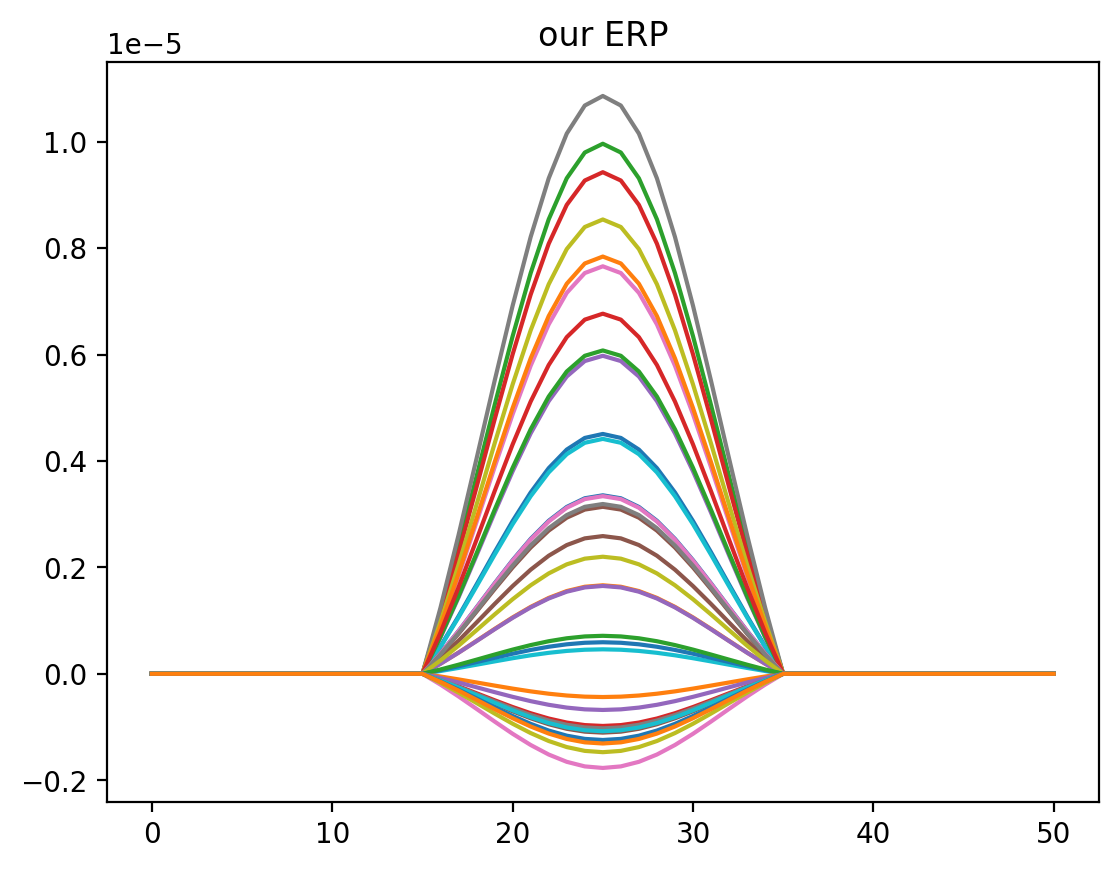

In [6]:
pre_stim = np.zeros(15)
post_stim = np.zeros(15)
erp = minmax_scale(norm.pdf(np.linspace(-1.5, 1.5, 21)))

erp = np.hstack((pre_stim, erp, post_stim)) * 1e-5 * 1.5
erp = np.array([erp] * 32) * -topo[:, np.newaxis]

plt.plot(erp.T)
plt.title("our ERP")  # the sharp boundaries are intentional to make the onset objective

In [7]:
def make_epochs(effsize=1):
    try:
        onset = np.random.uniform()
        raw_ = raw.copy().crop(onset)
        epochs_onset = np.random.choice((0, 1, 2))
        events = mne.make_fixed_length_events(raw_, duration=.5)[epochs_onset::3]
        events = events[sorted(np.random.choice(len(events), size=100, replace=False))]
        events[::2, -1] += 1
        epochs = mne.Epochs(raw_, events, preload=True).apply_baseline().crop(0, .5)
        data = epochs.get_data(copy=False)
        data += (np.array([erp if ii % 2 else np.zeros(erp.shape) for ii, _ in enumerate(events)]) * effsize)
        return epochs
    except Exception:
        return make_epochs(effsize=effsize)

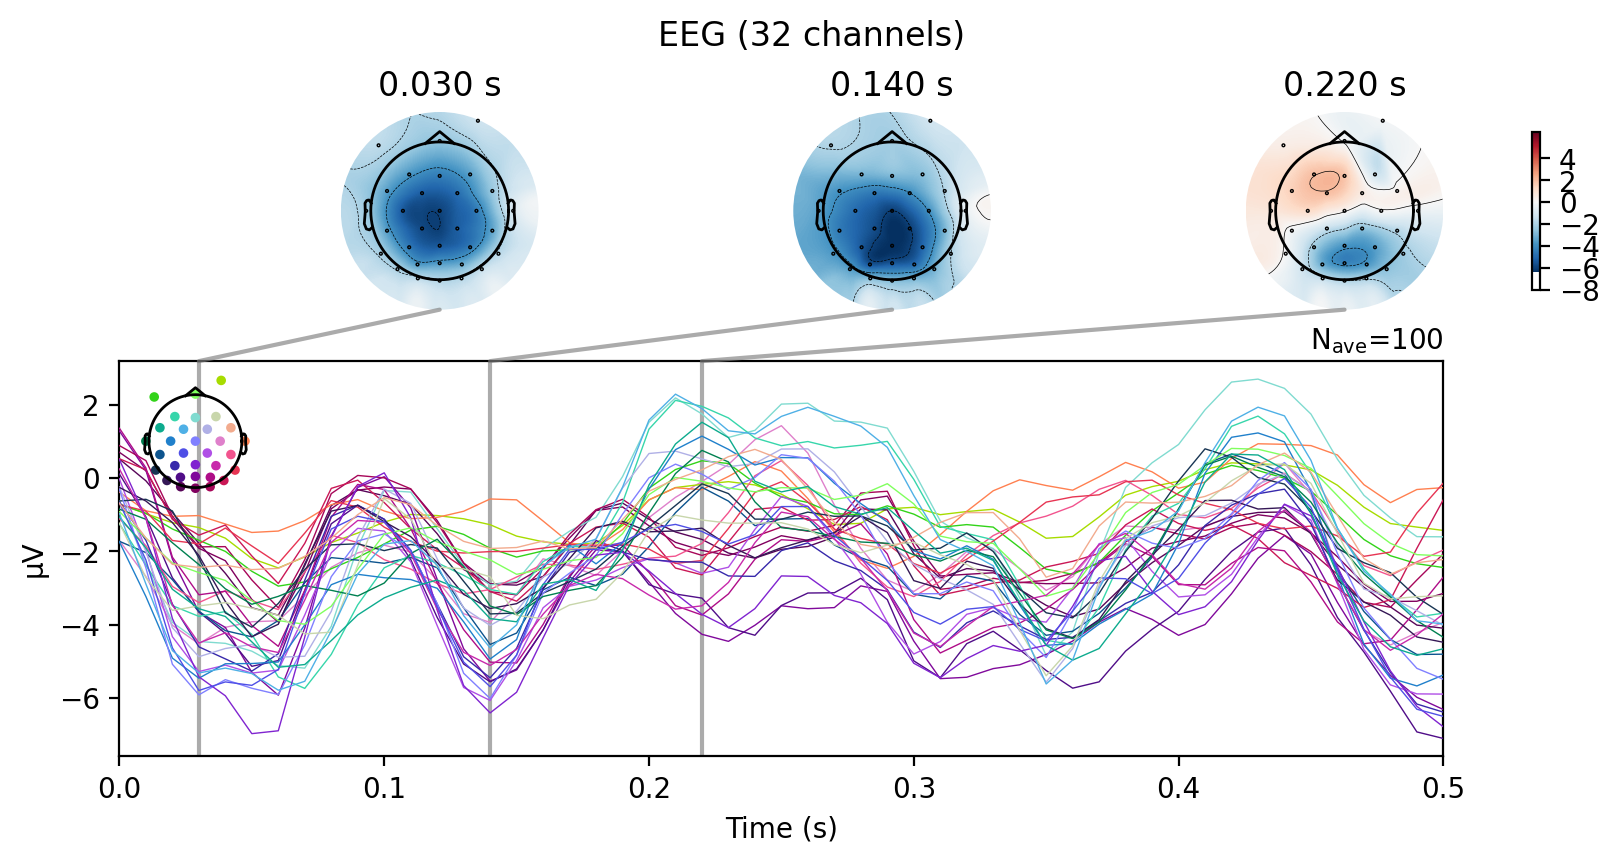

In [8]:
make_epochs().average().plot_joint();

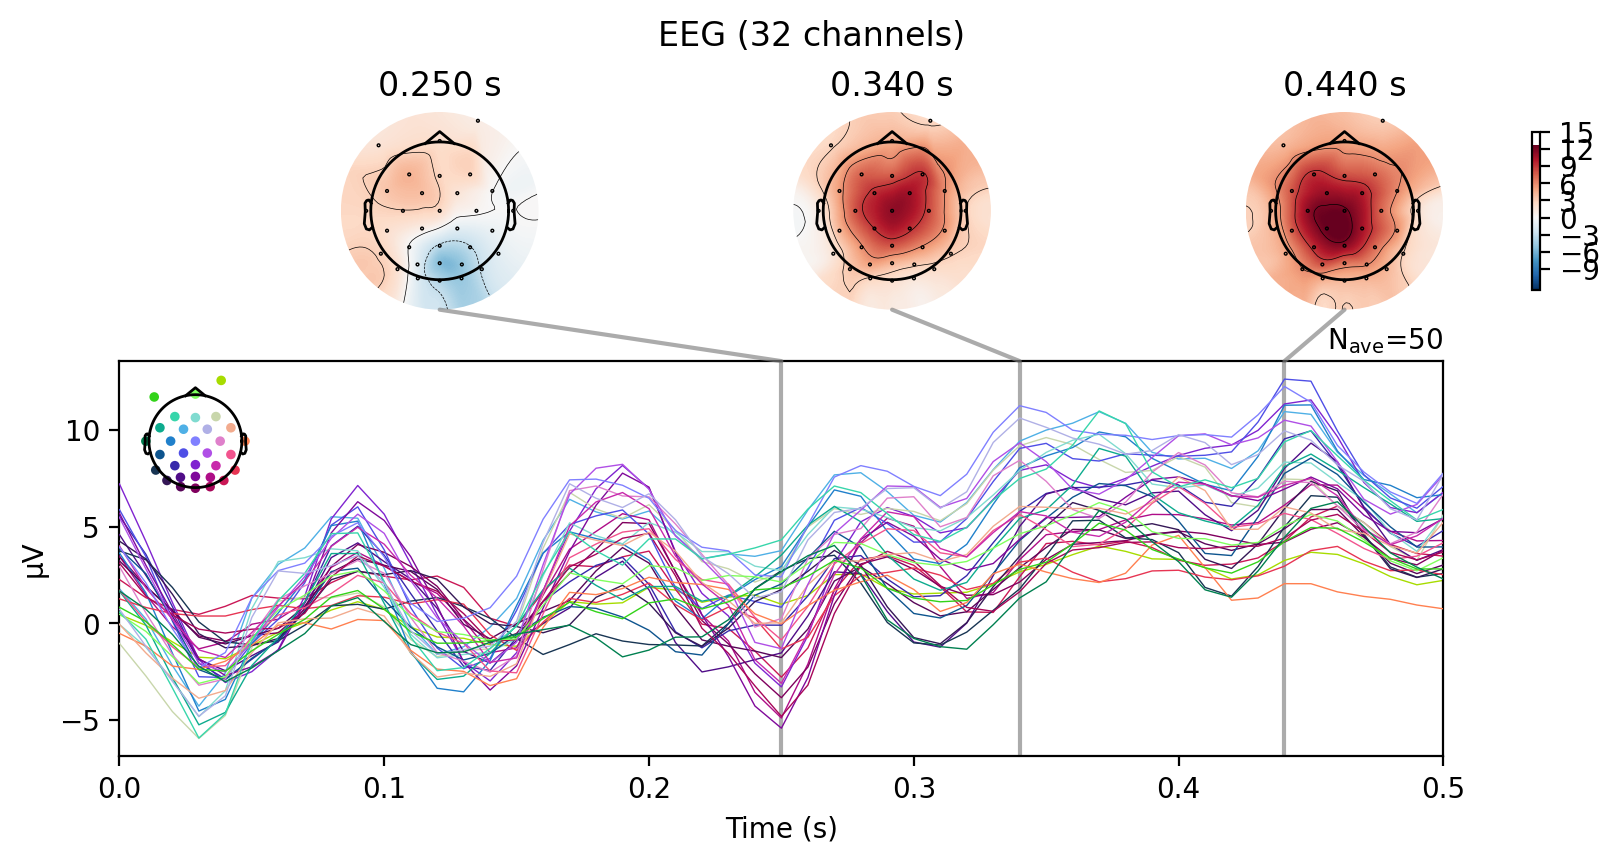

In [9]:
make_epochs()["2"].average().plot_joint();

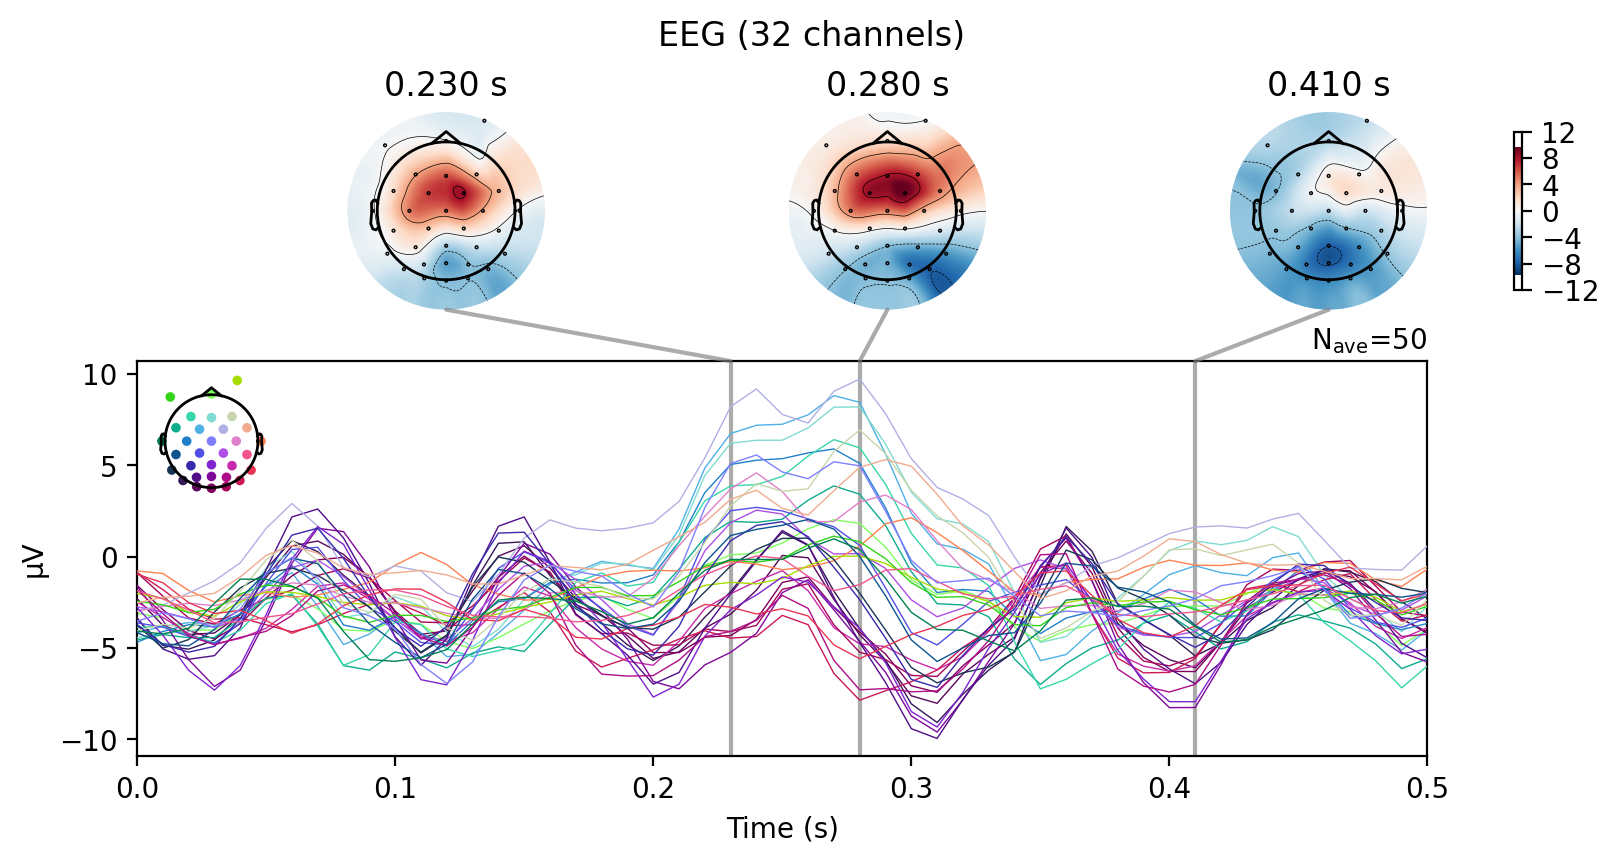

In [10]:
make_epochs()["1"].average().plot_joint();

In [16]:
def find_cluster_characteristics(epochs):
    data_1,  data_2 = epochs["1"].get_data(copy=False), epochs["2"].get_data(copy=False)
    res = mne.stats.permutation_cluster_test(
        [data_1.swapaxes(1, 2), data_2.swapaxes(1, 2)], n_permutations=1000,
        tail=1, adjacency=conn)                                                  ### changed from connectivity
    
    t_obs, clusters, cluster_pv, H0 = res
    
    # ValueError: setting an array element with a sequence.
    # The requested array has an inhomogeneous shape after 2 dimensions. 
    # The detected shape was (7, 2) + inhomogeneous part.

    # clusters is always rows x 2, some sub arrays are length 1, but need to restructure????
    # inhomogeneous part???

    sign_clusters = cluster_pv < .05
    if not sign_clusters.sum():
        return None  # no sign clusters
        
    # this is terribly convoluted, but it#s really only looking for the first datapoint
    # included in any significant cluster
    earliest_sign_datapoint = np.where((np.sum(np.array(clusters)[              ### error here due to structure of clusters???
        np.where(sign_clusters)[0]], 0).sum(1) > 0))[0].min()
    
    return earliest_sign_datapoint, sign_clusters.sum()

def make_one_run(ignore, effsize=1):
    return find_cluster_characteristics(make_epochs(effsize=effsize))

In [21]:
#%%capture

n = 10   # 10000 will take forever

all_results = dict()

effsizes = (.5, .75) # 1, 1.25, 1.5)

for ii, effsize in enumerate(effsizes):
    def make_one_run_(x):
        return make_one_run(x, effsize=effsize)
#    all_results[ii] = [make_one_run_(range(n) for _ in range(n))]
    with Pool() as p:
        all_results[ii] = list(tqdm.tqdm(p.imap(make_one_run_, range(n)), total=n))

  0%|                                                                                         | 0/10 [00:06<?, ?it/s]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (5, 2) + inhomogeneous part.

In [20]:
results = all_results[0]

claims = [r for r in results if r]
total_claims = len(claims)
print(total_claims)

(sum([r < 16 for r in claims if r]) / total_claims), total_claims

In [ ]:
fig, [ax1, ax2] = plt.subplots(ncols=2)
fig.set_size_inches(12, 4)

sns.distplot([r * 10 for r in claims], ax=ax1, kde_kws=dict(bw=10), bins=20)
ax1.axvline(16 * 10, c="crimson", label="real onset")
ax1.set_ylabel("cases (%)")
ax1.set_xlabel("earliest point included in any significant cluster (msec)")
ax1.set_yticklabels([round(label * 100, 2) for label in ax1.get_yticks()])
ax1.legend()
sns.despine()

ax2.axhline(.05, c="r", label="nominal 5% level")
ax2.set_ylabel("underestimations (cumulative %)")
ax2.set_xlabel("degree of underestimation of onset (msec)")
s = ((pd.Series(([-min(r - 16, 0) * 10 for r in claims])).value_counts() / total_claims)
     .sort_index(ascending=False).cumsum().sort_index())[1:]
s.plot(ax=ax2, kind="bar", color="C1")
ax2.set_yticklabels([int(label * 100) for label in ax2.get_yticks()])
sns.despine()

fig.savefig("figs/clusterfa.pdf", bbox_inches="tight")

In [ ]:
n_clus = [r[1] for r in results if r]
pd.Series(n_clus).value_counts() / len(n_clus) * 100

In [ ]:
errors = []

for ii, effsize in enumerate(effsizes):
    results = all_results[ii]
    claims = [r[0] for r in results if r]
    total_claims = len(claims)
    early = sum([r < 16 for r in claims if r]) / total_claims
    late = sum([r > 17 for r in claims if r]) / total_claims
    errors.append((early, late))

In [ ]:
plt.plot(effsizes, errors)